# 웹 크롤링 프로젝트 
### 작성자: 배선화

* 주제 : Naver 증권 데이터 수집 
* 수집 대상 : 한국 프로야구 10개 구단주들의 일별시세
* 수집 기간 : 2024년 3월 1일부터 2024년 5월 14일까지

1. 데이터 불러오기  
    (1) 웹 크롤링을 위한 라이브러리 import

In [4]:
import pandas as pd
import selenium
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.by import By
import time

1. 데이터 불러오기  
    (2) ChromeDriver를 활용하여 네이버 메인 호출 > 증권 페이지 이동

In [6]:
# Selenium 웹 드라이버 서비스 설정, 실행
service = Service(executable_path='chromedriver.exe')
driver = webdriver.Chrome(service=service)

# 네이버 메인 페이지로 이동
driver.get("https://www.naver.com")

# 증권 탭의 링크 주소 얻기
finance_link = driver.find_element(By.XPATH, '//*[@id="shortcutArea"]/ul/li[6]/a')
finance_url = finance_link.get_attribute('href')

# 링크 URL로 직접 이동
driver.get(finance_url)
time.sleep(2)

1. 데이터 불러오기  
    (3) 웹 페이지 구조 파악 (F12 개발자도구 활용)

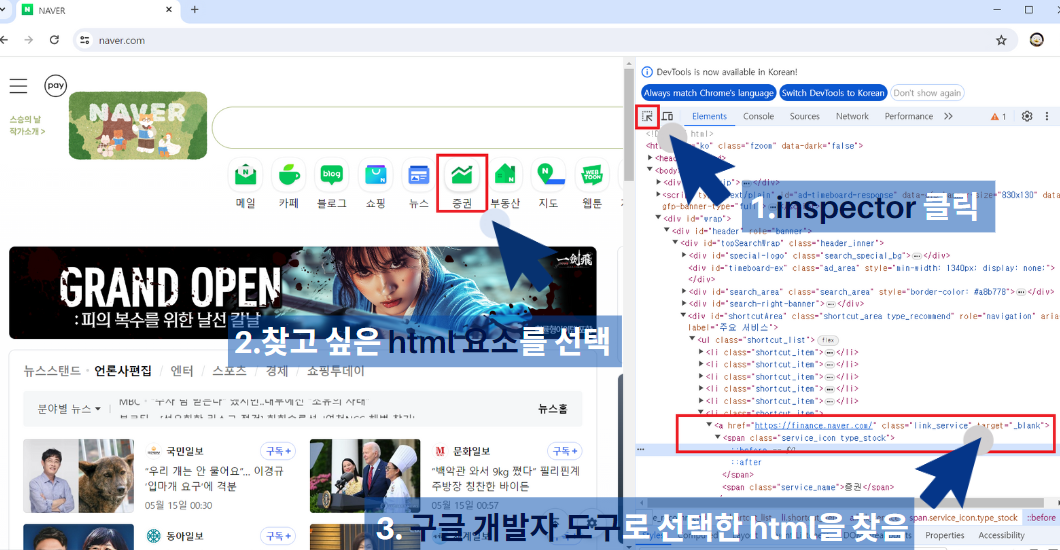
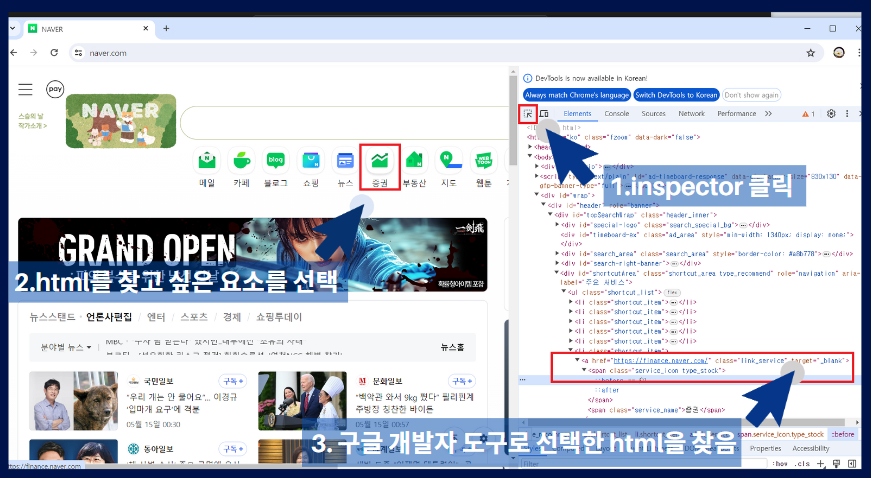

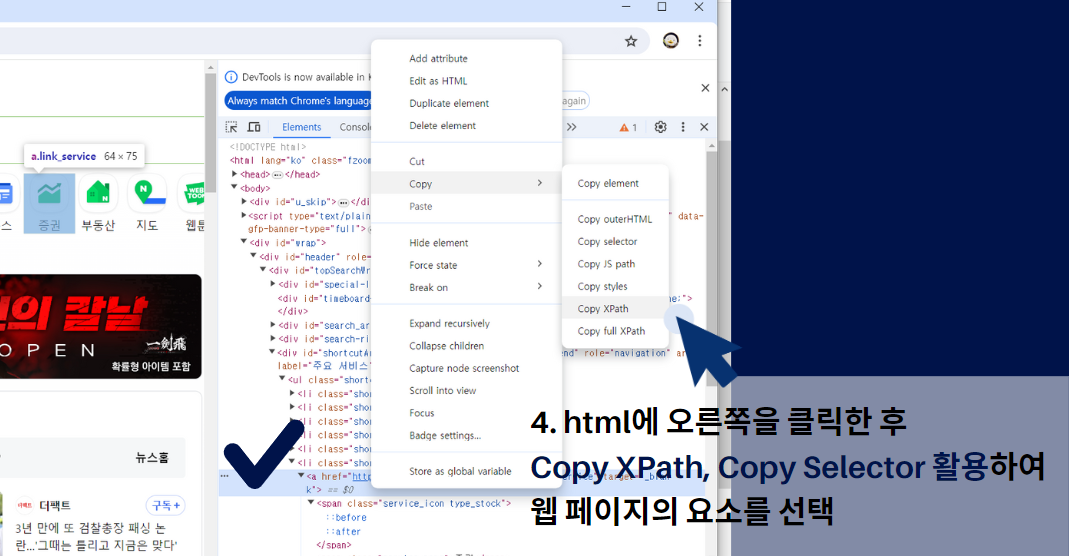

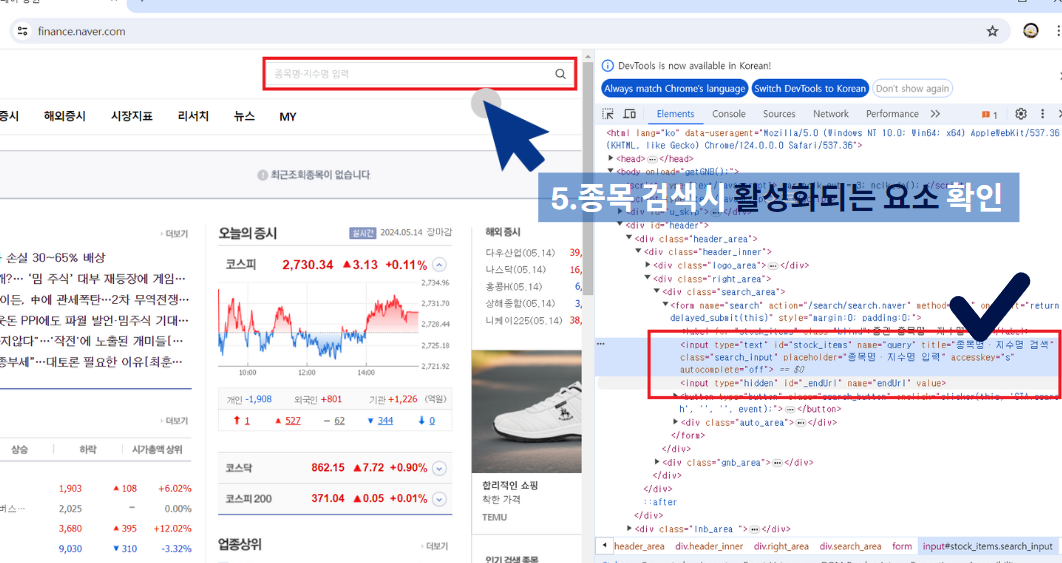

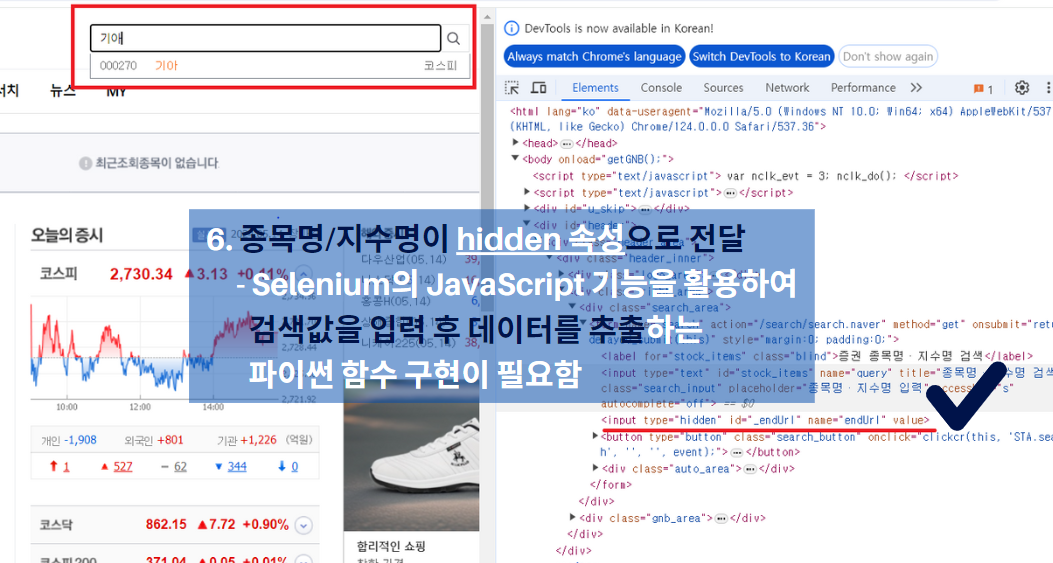

2. Selenium, webdriver를 사용하여 데이터 크롤링  
   (1) 종목 코드 하나를 입력 후 데이터 추출

In [9]:
# 검색 필드가 로드될 때까지 기다리기
search_field = WebDriverWait(driver, 10).until(
    EC.presence_of_element_located((By.ID, "stock_items"))
)

# 검색할 종목 코드 설정
search_codes = {'000270': '기아'}
search_code = '000270'  # 사용할 코드

# JavaScript를 사용하여 검색 필드에 값 설정
driver.execute_script("arguments[0].value = arguments[1];", search_field, search_code)

# ENTER 키를 보내 검색 실행
search_field.send_keys(Keys.ENTER)
time.sleep(5)

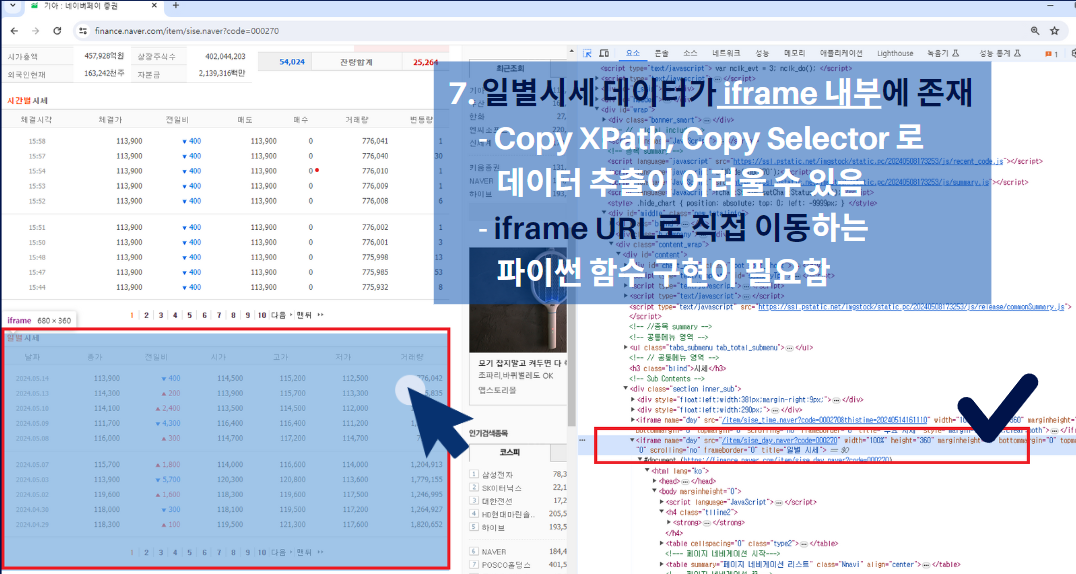

In [11]:
# 종목의 시세 페이지로 이동
market_price = driver.find_element(By.XPATH, '//*[@id="content"]/ul/li[2]/a')
market_price.click()
time.sleep(2)

# 일별 시세 테이블이 iframe에 있음
iframe_url = f"{finance_url}/item/sise_day.naver?code={search_code}"

# iframe URL로 직접 이동
driver.get(iframe_url)

In [12]:
# 데이터를 저장할 빈 리스트 생성
data = []

# 테이블이 완전히 보이고 상호작용이 가능하도록 대기
#            |-> Driver가 접근할 때 최대 10초까지 기다려라
table = WebDriverWait(driver, 10).until(EC.presence_of_element_located((By.CSS_SELECTOR, 'table.type2')))
#                                   |->  until~ : XPATH로 찾는 element의 위치/존재가 확인될 때까지
trs = table.find_elements(By.CSS_SELECTOR, 'tbody > tr')


# 테이블에서 모든 행을 순회
for tr in trs:
    spans = tr.find_elements(By.TAG_NAME, 'span')
    
    # 각 행에서 기대하는 최소한의 span 수 확인
    if len(spans) < 8:
        continue  # span 요소가 8개 미만이면 다음 행으로 넘어감
    
    # 유효한 행인 경우, 데이터 추출
    data_info = {
        '종목명': search_codes[search_code],  # 종목명을 딕셔너리에서 가져와 저장
        '날짜': spans[0].text,
        '종가': spans[1].text,
        '전일비상태': spans[2].text,
        '전일비': spans[3].text,
        '시가': spans[4].text,
        '고가': spans[5].text,
        '저가': spans[6].text,
        '거래량': spans[7].text
    }
    data.append(data_info)

    
# 종료
driver.quit()

2. Selenium, webdriver를 사용하여 데이터 크롤링  
   (2) 데이터 프레임 생성 후 확인

In [13]:
# 데이터 프레임 생성
df = pd.DataFrame(data)
df

,종목명,날짜,종가,전일비상태,전일비,시가,고가,저가,거래량
0,기아,2024.05.14,"113,900",하락,400,"114,500","115,200","112,500","776,042"
1,기아,2024.05.13,"114,300",상승,200,"113,900","115,700","113,300","935,835"
2,기아,2024.05.10,"114,100",상승,"2,400","113,500","114,500","112,000","1,422,408"
3,기아,2024.05.09,"111,700",하락,"4,300","116,400","116,400","111,200","1,762,344"
4,기아,2024.05.08,"116,000",상승,300,"114,700","117,200","114,700","792,482"
5,기아,2024.05.07,"115,700",상승,"1,800","114,000","116,600","114,000","1,204,913"
6,기아,2024.05.03,"113,900",하락,"5,700","120,300","120,800","113,600","1,779,155"
7,기아,2024.05.02,"119,600",상승,"1,600","118,300","119,600","117,500","1,246,995"
8,기아,2024.04.30,"118,000",하락,300,"118,100","119,500","117,200","1,264,927"
9,기아,2024.04.29,"118,300",상승,100,"119,500","121,300","117,600","1,820,652"


In [17]:
# 데이터 프레임 생성
df = pd.DataFrame(data)
#'날짜' 컬럼에서 '월'을 추출하여 정수로 변환
df['월'] = df['날짜'].apply(lambda x: int(x.split('.')[1]))

In [16]:
df

,종목명,날짜,종가,전일비상태,전일비,시가,고가,저가,거래량,월
0,기아,2024.05.14,"113,900",하락,400,"114,500","115,200","112,500","776,042",5
1,기아,2024.05.13,"114,300",상승,200,"113,900","115,700","113,300","935,835",5
2,기아,2024.05.10,"114,100",상승,"2,400","113,500","114,500","112,000","1,422,408",5
3,기아,2024.05.09,"111,700",하락,"4,300","116,400","116,400","111,200","1,762,344",5
4,기아,2024.05.08,"116,000",상승,300,"114,700","117,200","114,700","792,482",5
5,기아,2024.05.07,"115,700",상승,"1,800","114,000","116,600","114,000","1,204,913",5
6,기아,2024.05.03,"113,900",하락,"5,700","120,300","120,800","113,600","1,779,155",5
7,기아,2024.05.02,"119,600",상승,"1,600","118,300","119,600","117,500","1,246,995",5
8,기아,2024.04.30,"118,000",하락,300,"118,100","119,500","117,200","1,264,927",4
9,기아,2024.04.29,"118,300",상승,100,"119,500","121,300","117,600","1,820,652",4


2. Selenium, webdriver를 사용하여 크롤링  
    (3) 종목 코드 하나를 입력 후 페이지별로 데이터 추출

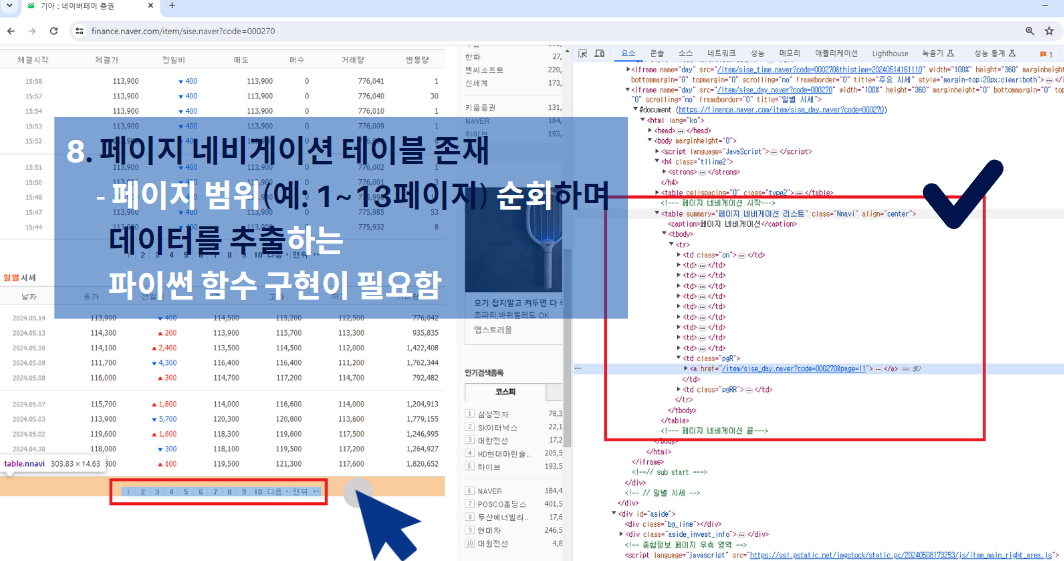

In [22]:
# Selenium 웹 드라이버 서비스 설정, 실행
service = Service(executable_path='chromedriver.exe')
driver = webdriver.Chrome(service=service)

# 네이버 메인 페이지로 이동
driver.get("https://www.naver.com")

# 증권 탭의 링크 주소 얻기
finance_link = driver.find_element(By.XPATH, '//*[@id="shortcutArea"]/ul/li[6]/a')
finance_url = finance_link.get_attribute('href')

# 링크 URL로 직접 이동
driver.get(finance_url)
time.sleep(2)

# 검색 필드가 로드될 때까지 기다리기
search_field = WebDriverWait(driver, 10).until(
    EC.presence_of_element_located((By.ID, "stock_items"))
)

# 검색할 종목 코드 설정
search_codes = {'000270': '기아'}
search_code = '000270'  # 사용할 코드

# JavaScript를 사용하여 검색 필드에 값 설정
driver.execute_script("arguments[0].value = arguments[1];", search_field, search_code)

# ENTER 키를 보내 검색 실행
search_field.send_keys(Keys.ENTER)
time.sleep(5)

# 종목의 시세 페이지로 이동
market_price = driver.find_element(By.XPATH, '//*[@id="content"]/ul/li[2]/a')
market_price.click()
time.sleep(2)

# 일별 시세 테이블이 iframe에 있음
iframe_url = f"{finance_url}/item/sise_day.naver?code={search_code}"

# iframe URL로 직접 이동
driver.get(iframe_url)

# 데이터를 저장할 빈 리스트 생성
data2 = []

for page_num in range(1, 13) : #1부터 70까지 반복 (되는 거 확인하면 나중에 바꾸자!)
    # 테이블이 완전히 보이고 상호작용이 가능하도록 대기
    #            |-> Driver가 접근할 때 최대 10초까지 기다려라
    table = WebDriverWait(driver, 10).until(EC.presence_of_element_located((By.CSS_SELECTOR, 'table.type2')))
    #                                   |->  until~ : XPATH로 찾는 element의 위치/존재가 확인될 때까지
    trs = table.find_elements(By.CSS_SELECTOR, 'tbody > tr')
    paginate = driver.find_element(By.XPATH,'/html/body/table[2]/tbody/tr/td')
    
    # 현재 몇 페이지 크롤링 중인지, 출력
    print("현재 페이지: ",page_num)
    
    # 테이블에서 모든 행을 순회
    for tr in trs:
        spans = tr.find_elements(By.TAG_NAME, 'span')
        
        # 각 행에서 기대하는 최소한의 span 수 확인
        if len(spans) < 8:
            continue  # span 요소가 8개 미만이면 다음 행으로 넘어감
        
        # 유효한 행인 경우, 데이터 추출
        data_info = {
            '종목명': search_codes[search_code],  # 종목명을 딕셔너리에서 가져와 저장
            '날짜': spans[0].text,
            '종가': spans[1].text,
            '전일비상태': spans[2].text,
            '전일비': spans[3].text,
            '시가': spans[4].text,
            '고가': spans[5].text,
            '저가': spans[6].text,
            '거래량': spans[7].text
        }
        data2.append(data_info)
        
    # 다음 페이지로 이동 
    try :
        # 페이지가 1~9, 11~19, 21~29
        if page_num % 10 != 0:
            next_link = paginate.find_element(By.XPATH, f"//a[contains(text(), '{page_num + 1}')]")
            next_link.click()
        # 페이지가 10, 20, 30,...
        else:                                      
            next_link = paginate.find_element(By.XPATH, "//a[contains(text(), '다음')]")
            next_link.click()
        time.sleep(2)  
    except :
        print("마지막 페이지에 도달했습니다.")
        break

# 종료
driver.quit()

# 데이터 확인
# print(data2)

현재 페이지:  1
현재 페이지:  2
현재 페이지:  3
현재 페이지:  4
현재 페이지:  5
현재 페이지:  6
현재 페이지:  7
현재 페이지:  8
현재 페이지:  9
현재 페이지:  10
현재 페이지:  11
현재 페이지:  12
[{'종목명': '기아', '날짜': '2024.05.14', '종가': '113,900', '전일비상태': '하락', '전일비': '400', '시가': '114,500', '고가': '115,200', '저가': '112,500', '거래량': '776,042'}, {'종목명': '기아', '날짜': '2024.05.13', '종가': '114,300', '전일비상태': '상승', '전일비': '200', '시가': '113,900', '고가': '115,700', '저가': '113,300', '거래량': '935,835'}, {'종목명': '기아', '날짜': '2024.05.10', '종가': '114,100', '전일비상태': '상승', '전일비': '2,400', '시가': '113,500', '고가': '114,500', '저가': '112,000', '거래량': '1,422,408'}, {'종목명': '기아', '날짜': '2024.05.09', '종가': '111,700', '전일비상태': '하락', '전일비': '4,300', '시가': '116,400', '고가': '116,400', '저가': '111,200', '거래량': '1,762,344'}, {'종목명': '기아', '날짜': '2024.05.08', '종가': '116,000', '전일비상태': '상승', '전일비': '300', '시가': '114,700', '고가': '117,200', '저가': '114,700', '거래량': '792,482'}, {'종목명': '기아', '날짜': '2024.05.07', '종가': '115,700', '전일비상태': '상승', '전일비': '1,800', '시가': '114,000', '고가': '

In [25]:
# 데이터 프레임 생성
df2 = pd.DataFrame(data2)
#'날짜' 컬럼에서 '월'을 추출하여 정수로 변환
df2['월'] = df2['날짜'].apply(lambda x: int(x.split('.')[1]))
df2

,종목명,날짜,종가,전일비상태,전일비,시가,고가,저가,거래량,월
0,기아,2024.05.14,"113,900",하락,400,"114,500","115,200","112,500","776,042",5
1,기아,2024.05.13,"114,300",상승,200,"113,900","115,700","113,300","935,835",5
2,기아,2024.05.10,"114,100",상승,"2,400","113,500","114,500","112,000","1,422,408",5
3,기아,2024.05.09,"111,700",하락,"4,300","116,400","116,400","111,200","1,762,344",5
4,기아,2024.05.08,"116,000",상승,300,"114,700","117,200","114,700","792,482",5
...,...,...,...,...,...,...,...,...,...,...
115,기아,2023.11.22,"83,100",하락,500,"83,000","83,400","82,200","730,476",11
116,기아,2023.11.21,"83,600",하락,800,"84,400","84,600","83,600","916,802",11
117,기아,2023.11.20,"84,400",하락,800,"84,600","84,900","83,700","973,922",11
118,기아,2023.11.17,"85,200",상승,700,"84,100","85,300","83,600","1,271,006",11


2. Selenium, webdriver를 사용하여 크롤링  
    (4) 종목 코드 10개 데이터 추출

In [28]:
# Selenium 웹 드라이버 서비스 설정, 실행
service = Service(executable_path='chromedriver.exe')
driver = webdriver.Chrome(service=service)

# 네이버 메인 페이지로 이동
driver.get("https://www.naver.com")

# 증권 탭의 링크 주소 얻기
finance_link = driver.find_element(By.XPATH, '//*[@id="shortcutArea"]/ul/li[6]/a')
finance_url = finance_link.get_attribute('href')

# 링크 URL로 직접 이동
driver.get(finance_url)
time.sleep(2)

# 검색 페이지 URL 저장
search_page_url = driver.current_url

# 검색할 종목 코드 설정
search_codes = {'000270': '기아',
                '030200': 'KT',
                '003550': 'LG',
                '036570': '엔씨소프트',
                '004170': '신세계',
                '000150': '두산',
                '004990': '롯데지주',
                '005930': '삼성전자',
                '039490': '키움증권',
                '000880': '한화'}

all_data = []  # 모든 종목의 데이터를 저장할 리스트

for search_code in search_codes:
    # 검색 페이지로 다시 이동
    driver.get(search_page_url)
    time.sleep(2)
    
    # 검색 필드가 로드될 때까지 기다리기
    search_field = WebDriverWait(driver, 10).until(
        EC.presence_of_element_located((By.ID, "stock_items"))
    )
    
    # 검색 필드 초기화
    search_field.clear()
    
    # JavaScript를 사용하여 검색 필드에 값 설정
    driver.execute_script("arguments[0].value = arguments[1];", search_field, search_code)
    
    # ENTER 키를 보내 검색 실행
    search_field.send_keys(Keys.ENTER)
    time.sleep(5)
    
    # 종목의 시세 페이지로 이동
    market_price_link = WebDriverWait(driver, 10).until(
        EC.presence_of_element_located((By.XPATH, '//*[@id="content"]/ul/li[2]/a'))
    )
    market_price_link.click()
    time.sleep(2)
    
    # 일별 시세 테이블이 iframe에 있음
    iframe_url = f"{finance_url}/item/sise_day.naver?code={search_code}"

    # iframe URL로 직접 이동
    driver.get(iframe_url)

    # 데이터를 저장할 빈 리스트 생성
    data = []

    # 테이블이 완전히 보이고 상호작용이 가능하도록 대기
    table = WebDriverWait(driver, 10).until(EC.presence_of_element_located((By.CSS_SELECTOR, 'table.type2')))
    trs = table.find_elements(By.CSS_SELECTOR, 'tbody > tr')

    # 테이블에서 모든 행을 순회
    for tr in trs:
        spans = tr.find_elements(By.TAG_NAME, 'span')
        
        # 각 행에서 기대하는 최소한의 span 수 확인
        if len(spans) < 8:
            continue  # span 요소가 8개 미만이면 다음 행으로 넘어감
        
        # 유효한 행인 경우, 데이터 추출
        data_info = {
            '종목명': search_codes[search_code],  # 종목명을 딕셔너리에서 가져와 저장
            '날짜': spans[0].text,
            '종가': spans[1].text,
            '전일비상태': spans[2].text,
            '전일비': spans[3].text,
            '시가': spans[4].text,
            '고가': spans[5].text,
            '저가': spans[6].text,
            '거래량': spans[7].text
        }
        data.append(data_info)
    
    all_data.extend(data)  # 각 종목의 데이터를 전체 데이터 리스트에 추가

# 종료
driver.quit()

In [30]:
# 모든 데이터를 DataFrame으로 변환
df3 = pd.DataFrame(all_data)

# '날짜' 컬럼에서 '월'을 추출하여 정수로 변환
df3['월'] = df3['날짜'].apply(lambda x: int(x.split('.')[1]))
df3

,종목명,날짜,종가,전일비상태,전일비,시가,고가,저가,거래량,월
0,기아,2024.05.14,"113,900",하락,400,"114,500","115,200","112,500","776,042",5
1,기아,2024.05.13,"114,300",상승,200,"113,900","115,700","113,300","935,835",5
2,기아,2024.05.10,"114,100",상승,"2,400","113,500","114,500","112,000","1,422,408",5
3,기아,2024.05.09,"111,700",하락,"4,300","116,400","116,400","111,200","1,762,344",5
4,기아,2024.05.08,"116,000",상승,300,"114,700","117,200","114,700","792,482",5
...,...,...,...,...,...,...,...,...,...,...
95,한화,2024.05.07,"27,100",상승,150,"27,200","27,300","26,800","184,473",5
96,한화,2024.05.03,"26,950",하락,250,"27,300","27,450","26,950","135,260",5
97,한화,2024.05.02,"27,200",하락,150,"27,300","27,500","26,850","217,357",5
98,한화,2024.04.30,"27,350",하락,450,"27,800","27,850","27,200","211,211",4


2. Selenium, webdriver를 사용하여 크롤링 (최종 코드)  
    (5) 종목 코드 10개 입력 후 페이지별로 데이터 추출  
         - 야구 시즌이 3월부터 시작, 10개 구단에 대하여 데이터 크롤링 종료 조건 추가

In [32]:
# Selenium 웹 드라이버 서비스 설정, 실행
service = Service(executable_path='chromedriver.exe')
driver = webdriver.Chrome(service=service)

# 네이버 메인 페이지로 이동
driver.get("https://www.naver.com")

# 증권 탭의 링크 주소 얻기
finance_link = driver.find_element(By.XPATH, '//*[@id="shortcutArea"]/ul/li[6]/a')
finance_url = finance_link.get_attribute('href')

# 링크 URL로 직접 이동
driver.get(finance_url)
time.sleep(2)

# 검색 페이지 URL 저장
search_page_url = driver.current_url

# 검색할 종목 코드 설정
search_codes = {'000270': '기아',
                '030200': 'KT',
                '003550': 'LG',
                '036570': '엔씨소프트',
                '004170': '신세계',
                '000150': '두산',
                '004990': '롯데지주',
                '005930': '삼성전자',
                '039490': '키움증권',
                '000880': '한화'}

all_data = []  # 모든 종목의 데이터를 저장할 리스트

for search_code in search_codes:
    # 검색 페이지로 다시 이동
    driver.get(search_page_url)
    time.sleep(2)
    
    # 검색 필드가 로드될 때까지 기다리기
    search_field = WebDriverWait(driver, 10).until(
        EC.presence_of_element_located((By.ID, "stock_items"))
    )
    
    # 검색 필드 초기화
    search_field.clear()
    
    # JavaScript를 사용하여 검색 필드에 값 설정
    driver.execute_script("arguments[0].value = arguments[1];", search_field, search_code)
    
    # ENTER 키를 보내 검색 실행
    search_field.send_keys(Keys.ENTER)
    time.sleep(5)
    
    # 종목의 시세 페이지로 이동
    market_price_link = WebDriverWait(driver, 10).until(
        EC.presence_of_element_located((By.XPATH, '//*[@id="content"]/ul/li[2]/a'))
    )
    market_price_link.click()
    time.sleep(2)
    
    # 일별 시세 테이블이 iframe에 있음
    iframe_url = f"{finance_url}/item/sise_day.naver?code={search_code}"

    # iframe URL로 직접 이동
    driver.get(iframe_url)

    # 데이터를 저장할 빈 리스트 생성
    data = []
    
    for page_num in range(1, 13) :
        table = WebDriverWait(driver, 10).until(EC.presence_of_element_located((By.CSS_SELECTOR, 'table.type2')))
        trs = table.find_elements(By.CSS_SELECTOR, 'tbody > tr')
        paginate = driver.find_element(By.XPATH,'/html/body/table[2]/tbody/tr/td')
    
        # 현재 몇 페이지 크롤링 중인지, 출력
        print("현재 페이지: ",page_num)
        
        # 테이블에서 모든 행을 순회
        for tr in trs:
            spans = tr.find_elements(By.TAG_NAME, 'span')
            
            # 각 행에서 기대하는 최소한의 span 수 확인
            if len(spans) < 8:
                continue  # span 요소가 8개 미만이면 다음 행으로 넘어감
            
            # 야구 정규 시즌 3월 부터 시작
            target_date = '2024.02.29'
            date_text = spans[0].text
            # print("읽은 날짜:", date_text)  # 디버깅을 위한 출력
            
            if date_text == target_date:
                print("목표 날짜에 도달했습니다. 데이터 수집을 종료합니다.")
                break  # 내부 반복문 종료
            
            # 유효한 행인 경우, 데이터 추출
            data_info = {
                '종목명': search_codes[search_code],  # 종목명을 딕셔너리에서 가져와 저장
                '날짜': spans[0].text,
                '종가': spans[1].text,
                '전일비상태': spans[2].text,
                '전일비': spans[3].text,
                '시가': spans[4].text,
                '고가': spans[5].text,
                '저가': spans[6].text,
                '거래량': spans[7].text
            }
            data.append(data_info)
            
        if date_text == target_date:
            # print("외부 반복문을 종료합니다.")
            break

        # 다음 페이지로 이동 
        try :
            # 페이지가 1~9, 11~19, 21~29
            if page_num % 10 != 0:
                next_link = driver.find_element(By.XPATH, f"//a[contains(text(), '{page_num + 1}')]")
                next_link.click()
            # 페이지가 10, 20, 30,...
            else:
                next_link = driver.find_element(By.XPATH, "//a[contains(text(), '다음')]")
                next_link.click()
            time.sleep(2)  
        except :
            print("마지막 페이지에 도달했습니다.")
            break
        
    all_data.extend(data)  # 각 종목의 데이터를 전체 데이터 리스트에 추가

# 종료
driver.quit()

# 데이터프레임 생성
df = pd.DataFrame(all_data)
df

현재 페이지:  1
현재 페이지:  2
현재 페이지:  3
현재 페이지:  4
현재 페이지:  5
목표 날짜에 도달했습니다. 데이터 수집을 종료합니다.
현재 페이지:  1
현재 페이지:  2
현재 페이지:  3
현재 페이지:  4
현재 페이지:  5
목표 날짜에 도달했습니다. 데이터 수집을 종료합니다.
현재 페이지:  1
현재 페이지:  2
현재 페이지:  3
현재 페이지:  4
현재 페이지:  5
목표 날짜에 도달했습니다. 데이터 수집을 종료합니다.
현재 페이지:  1
현재 페이지:  2
현재 페이지:  3
현재 페이지:  4
현재 페이지:  5
목표 날짜에 도달했습니다. 데이터 수집을 종료합니다.
현재 페이지:  1
현재 페이지:  2
현재 페이지:  3
현재 페이지:  4
현재 페이지:  5
목표 날짜에 도달했습니다. 데이터 수집을 종료합니다.
현재 페이지:  1
현재 페이지:  2
현재 페이지:  3
현재 페이지:  4
현재 페이지:  5
목표 날짜에 도달했습니다. 데이터 수집을 종료합니다.
현재 페이지:  1
현재 페이지:  2
현재 페이지:  3
현재 페이지:  4
현재 페이지:  5
목표 날짜에 도달했습니다. 데이터 수집을 종료합니다.
현재 페이지:  1
현재 페이지:  2
현재 페이지:  3
현재 페이지:  4
현재 페이지:  5
목표 날짜에 도달했습니다. 데이터 수집을 종료합니다.
현재 페이지:  1
현재 페이지:  2
현재 페이지:  3
현재 페이지:  4
현재 페이지:  5
목표 날짜에 도달했습니다. 데이터 수집을 종료합니다.
현재 페이지:  1
현재 페이지:  2
현재 페이지:  3
현재 페이지:  4
현재 페이지:  5
목표 날짜에 도달했습니다. 데이터 수집을 종료합니다.


,종목명,날짜,종가,전일비상태,전일비,시가,고가,저가,거래량
0,기아,2024.05.14,"113,900",하락,400,"114,500","115,200","112,500","776,042"
1,기아,2024.05.13,"114,300",상승,200,"113,900","115,700","113,300","935,835"
2,기아,2024.05.10,"114,100",상승,"2,400","113,500","114,500","112,000","1,422,408"
3,기아,2024.05.09,"111,700",하락,"4,300","116,400","116,400","111,200","1,762,344"
4,기아,2024.05.08,"116,000",상승,300,"114,700","117,200","114,700","792,482"
...,...,...,...,...,...,...,...,...,...
485,한화,2024.03.08,"29,650",하락,100,"29,950","30,050","29,550","364,337"
486,한화,2024.03.07,"29,750",상승,200,"29,550","30,000","29,250","400,738"
487,한화,2024.03.06,"29,550",상승,150,"29,100","29,900","29,000","366,867"
488,한화,2024.03.05,"29,400",하락,300,"29,400","30,200","29,250","363,814"


In [38]:
# '날짜' 컬럼을 문자열로 변환
df['날짜'] = df['날짜'].astype(str)

# 문자열로 변환된 '날짜'에서 '월'을 추출하여 정수로 변환
# '5.08' 같은 형태는 '5.08'으로 변환된 후, '5'를 추출
df['월'] = df['날짜'].apply(lambda x: int(x.split('.')[1]))

# 결과 확인
print(df[['날짜', '월']].head(20))

            날짜  월
0   2024.05.14  5
1   2024.05.13  5
2   2024.05.10  5
3   2024.05.09  5
4   2024.05.08  5
5   2024.05.07  5
6   2024.05.03  5
7   2024.05.02  5
8   2024.04.30  4
9   2024.04.29  4
10  2024.04.26  4
11  2024.04.25  4
12  2024.04.24  4
13  2024.04.23  4
14  2024.04.22  4
15  2024.04.19  4
16  2024.04.18  4
17  2024.04.17  4
18  2024.04.16  4
19  2024.04.15  4


In [43]:
# 데이터를 날짜에 따라 오름차순으로 정렬
df = df.sort_values(by='날짜')
# 시가, 고가, 저가, 종가 열의 컴마 제거 및 타입 변환
df['시가'] = df['시가'].replace(',', '', regex=True).astype(float)
df['고가'] = df['고가'].replace(',', '', regex=True).astype(float)
df['저가'] = df['저가'].replace(',', '', regex=True).astype(float)
df['종가'] = df['종가'].str.replace(',', '').astype(int)
df['거래량'] = df['거래량'].str.replace(',', '').astype(int)

,종목명,날짜,종가,전일비상태,전일비,시가,고가,저가,거래량,월
244,신세계,2024.03.04,172100,하락,"2,700",174800.0,174900.0,170700.0,48308,3
440,키움증권,2024.03.04,132600,상승,"6,900",127900.0,133300.0,127800.0,167046,3
391,삼성전자,2024.03.04,74900,상승,"1,500",74300.0,75000.0,74000.0,23210474,3
342,롯데지주,2024.03.04,29950,하락,250,30550.0,30750.0,29750.0,232674,3
293,두산,2024.03.04,91100,상승,100,91000.0,91800.0,90300.0,68802,3
...,...,...,...,...,...,...,...,...,...,...
441,한화,2024.05.14,27150,하락,300,27550.0,27550.0,27000.0,173732,5
294,롯데지주,2024.05.14,26850,보합,0,26800.0,27100.0,26550.0,117899,5
343,삼성전자,2024.05.14,78300,하락,100,78600.0,78800.0,77900.0,11436590,5
98,LG,2024.05.14,80500,하락,500,81000.0,81200.0,80100.0,217970,5


3. Pandas를 활용해서 csv, json 파일로 저장

In [44]:
import os
from pathlib import Path

In [45]:
# csv 파일 저장
df.to_csv('naver_stocks.csv', index=False, encoding='utf-8-sig')

In [47]:
# csv 파일 읽어오기
df = pd.read_csv('naver_stocks.csv')
df

,종목명,날짜,종가,전일비상태,전일비,시가,고가,저가,거래량,월
0,신세계,2024.03.04,172100,하락,"2,700",174800.0,174900.0,170700.0,48308,3
1,키움증권,2024.03.04,132600,상승,"6,900",127900.0,133300.0,127800.0,167046,3
2,삼성전자,2024.03.04,74900,상승,"1,500",74300.0,75000.0,74000.0,23210474,3
3,롯데지주,2024.03.04,29950,하락,250,30550.0,30750.0,29750.0,232674,3
4,두산,2024.03.04,91100,상승,100,91000.0,91800.0,90300.0,68802,3
...,...,...,...,...,...,...,...,...,...,...
485,한화,2024.05.14,27150,하락,300,27550.0,27550.0,27000.0,173732,5
486,롯데지주,2024.05.14,26850,보합,0,26800.0,27100.0,26550.0,117899,5
487,삼성전자,2024.05.14,78300,하락,100,78600.0,78800.0,77900.0,11436590,5
488,LG,2024.05.14,80500,하락,500,81000.0,81200.0,80100.0,217970,5


In [48]:
# 정보 확인
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 490 entries, 0 to 489
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   종목명     490 non-null    object 
 1   날짜      490 non-null    object 
 2   종가      490 non-null    int64  
 3   전일비상태   490 non-null    object 
 4   전일비     490 non-null    object 
 5   시가      490 non-null    float64
 6   고가      490 non-null    float64
 7   저가      490 non-null    float64
 8   거래량     490 non-null    int64  
 9   월       490 non-null    int64  
dtypes: float64(3), int64(3), object(4)
memory usage: 38.4+ KB


In [49]:
# Null 확인
df.isnull().sum()

종목명      0
날짜       0
종가       0
전일비상태    0
전일비      0
시가       0
고가       0
저가       0
거래량      0
월        0
dtype: int64

In [50]:
# json파일을 저장할 디렉토리 생성
path = Path('myjson')
#존재하지 않을 경우는 디렉토리를 만들어 주기
if not path.exists():
    print(f"해당 {path}는 존재하지 않기 때문에 새로 생성합니다.")
    path.mkdir(parents=True)

해당 myjson는 존재하지 않기 때문에 새로 생성합니다.


In [51]:
# 파일로 저장
df.to_json(f'{path}/naver_stocks.json',force_ascii=False)

4. 시각화

In [52]:
# 시각화를 위한 라이브러리 import
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

#불필요한 경고문 삭제 
import warnings as wr
wr.filterwarnings(action='ignore')

# 한글 폰트 설정
plt.rc('font', family = 'Malgun Gothic')

In [54]:
# csv 파일 읽어오기
df = pd.read_csv('naver_stocks.csv')
df

,종목명,날짜,종가,전일비상태,전일비,시가,고가,저가,거래량,월
0,신세계,2024.03.04,172100,하락,"2,700",174800.0,174900.0,170700.0,48308,3
1,키움증권,2024.03.04,132600,상승,"6,900",127900.0,133300.0,127800.0,167046,3
2,삼성전자,2024.03.04,74900,상승,"1,500",74300.0,75000.0,74000.0,23210474,3
3,롯데지주,2024.03.04,29950,하락,250,30550.0,30750.0,29750.0,232674,3
4,두산,2024.03.04,91100,상승,100,91000.0,91800.0,90300.0,68802,3
...,...,...,...,...,...,...,...,...,...,...
485,한화,2024.05.14,27150,하락,300,27550.0,27550.0,27000.0,173732,5
486,롯데지주,2024.05.14,26850,보합,0,26800.0,27100.0,26550.0,117899,5
487,삼성전자,2024.05.14,78300,하락,100,78600.0,78800.0,77900.0,11436590,5
488,LG,2024.05.14,80500,하락,500,81000.0,81200.0,80100.0,217970,5


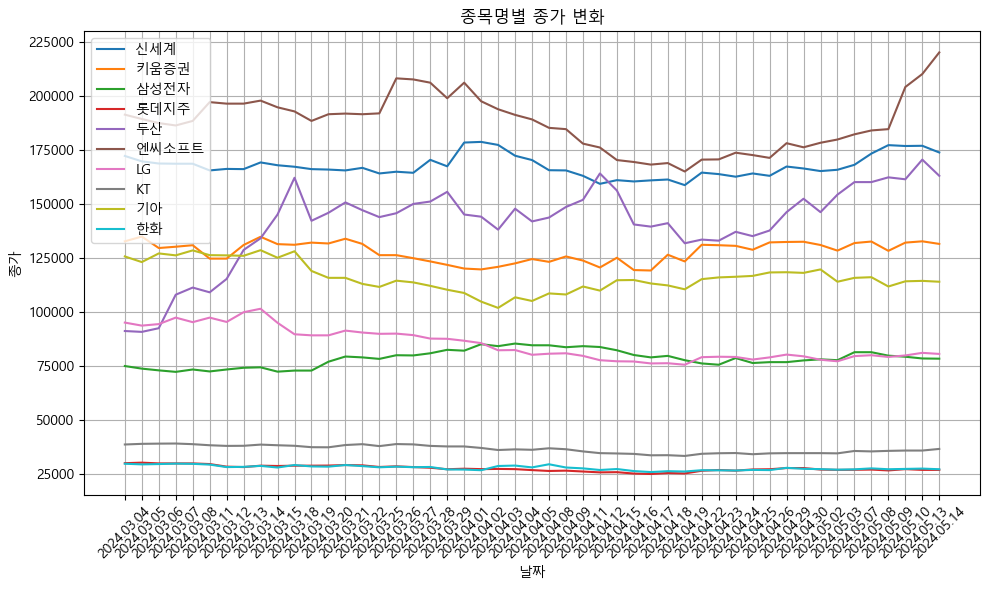

In [55]:
# 시각화 - 종목명별로 종가를 시계열 그래프로 표현
plt.figure(figsize=(10, 6))

for stock in df['종목명'].unique():
    subset = df[df['종목명'] == stock]
    plt.plot(subset['날짜'], subset['종가'], label=stock)

plt.title('종목명별 종가 변화')
plt.xlabel('날짜')
plt.ylabel('종가')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

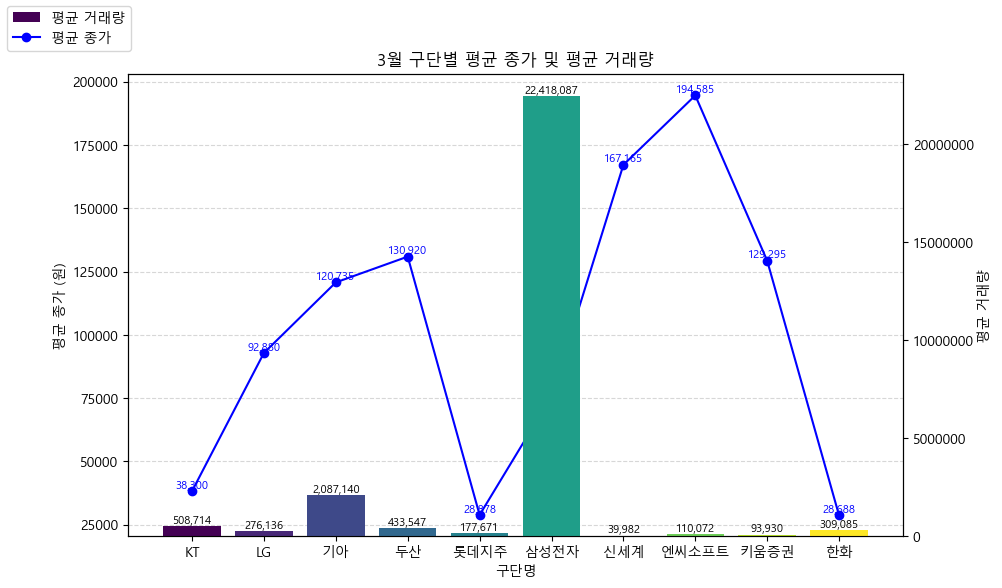

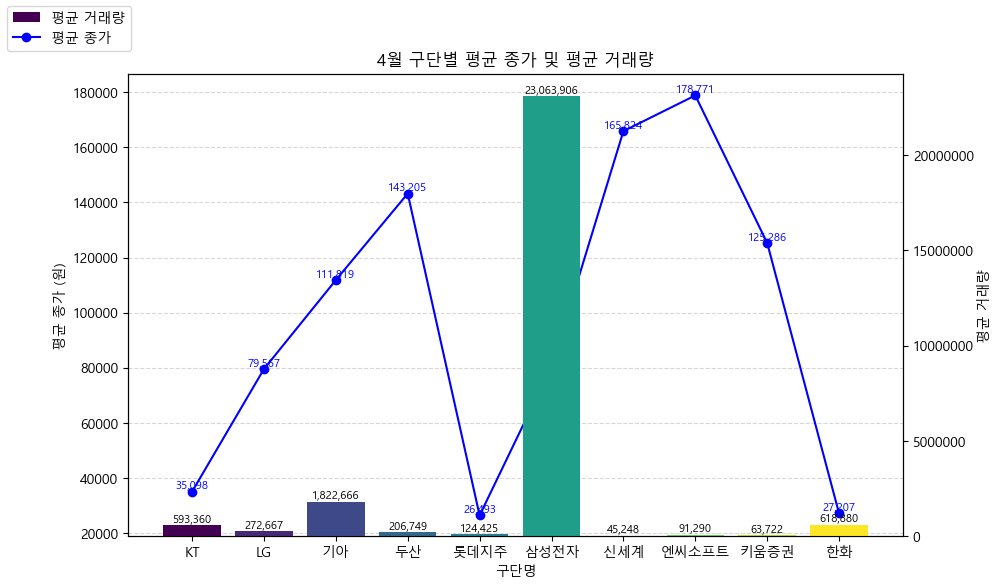

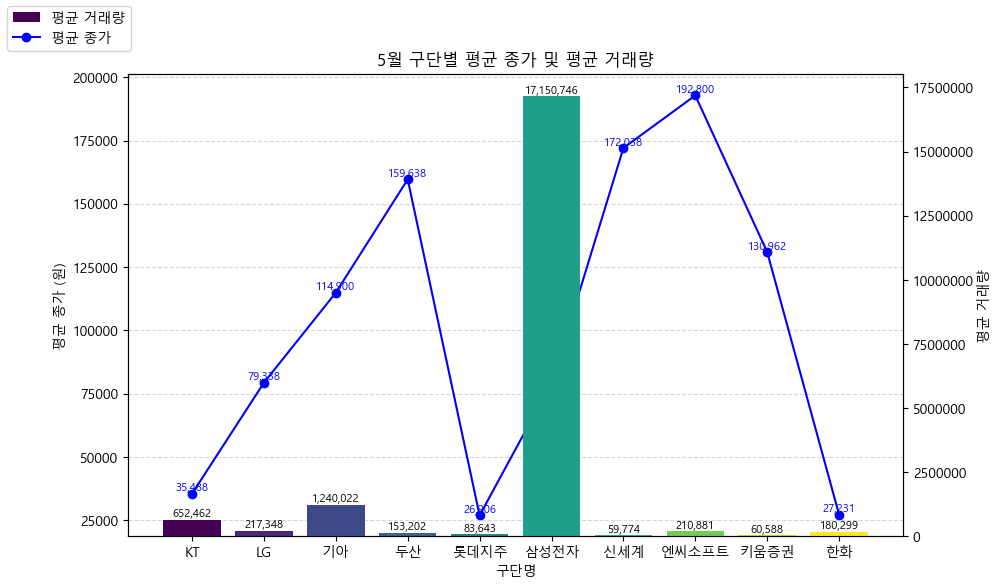

In [57]:
# 종목별, 월별로 그룹화하고 평균 종가와 평균 거래량 계산
grouped = df.groupby(['종목명', '월'])[['종가', '거래량']].mean().reset_index()

# 월별 그래프 생성
for month in sorted(grouped['월'].unique()):
    fig, ax1 = plt.subplots(figsize=(10, 6))
    month_data = grouped[grouped['월'] == month]
    
    # 숫자 형식을 일반 숫자로 변경
    ax1.ticklabel_format(style='plain', axis='y')
    
    num_bars = len(month_data['종목명'])
    colors = plt.get_cmap('viridis')(np.linspace(0, 1, num_bars))

    # 평균 종가를 선 그래프로 표시
    lines = ax1.plot(month_data['종목명'], month_data['종가'], 'o-', color='blue', label='평균 종가')
    ax1.set_xlabel('구단명')
    ax1.set_ylabel('평균 종가 (원)')
    ax1.tick_params(axis='y')
    ax1.ticklabel_format(style='plain', axis='y')

    # 평균 거래량을 바 차트로 표시
    ax2 = ax1.twinx()
    bars = ax2.bar(month_data['종목명'], month_data['거래량'], color=colors, label='평균 거래량')
    ax2.set_ylabel('평균 거래량')
    ax2.tick_params(axis='y')
    ax2.ticklabel_format(style='plain', axis='y')

    # 평균 종가 데이터 포인트 위에 값 표시
    for i, (x, y) in enumerate(zip(month_data['종목명'], month_data['종가'])):
        ax1.text(x, y, f'{y:,.0f}', color='blue', fontsize=8, verticalalignment='bottom', horizontalalignment='center')

    # 평균 거래량 데이터 포인트 위에 값 표시
    for i, (x, y) in enumerate(zip(month_data['종목명'], month_data['거래량'])):
        ax2.text(x, y, f'{y:,.0f}', color='black', fontsize=8, verticalalignment='bottom', horizontalalignment='center')

    plt.title(f'{month}월 구단별 평균 종가 및 평균 거래량')
    fig.legend(handles=[bars, lines[0]], labels=['평균 거래량', '평균 종가'], loc='upper left')
    ax1.grid(True, axis='y', linestyle='--', alpha=0.5)  # ax1 축에 그리드 적용
    plt.show()